In [1]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt

**IMPORTANT NOTE**: This handout notebook relies on functions from the **for-this-class-only** `mylib` package. To access this package, clone or download it from **[this GitHub page](https://github.com/aalgahmi/mylib)**. You can find instructions on how to clone this package on its main GitHub page, as well as in the `04.working_with_datasets.ipynb` notebook handout. Make sure to place the `mylib` folder from this package in the same directory as this notebook. Once you've completed this step, the following import should work seamlessly.

In [2]:
import mylib as my

# 9: Ensemble methods

The goal of ensemble methods to to reduce bias and/or variance which helps prevent overfitting. In this notebook we look at two main ensemble methods: bagging (including random forests) and boosting.

## Bagging (Bootstrap aggregation)

The simplest form of ensemble methods is called **bagging** which stands for **bootstrap aggregation**. The idea is simple:
* take $T$ bootstrap samples from the given dataset
* for each bootstrap sample, train a decision tree DT
* the predicted label of an unseen example is the average(for regression problems) or the plurality vote (for classification problems) of all the output predicted by all the trained $T$ trees.

### Bootstrap samples
Let's start by seeing how we can draw a bootstrap sample given a dataset $D$. A bootstrap sample is a sample drawn randomly with replacement from the given dataset such that the size of the sample is the same as the size of the original dataset. That means some examples will show up multiple times in the drawn sample.

In the example below, we are using a subset of the car dataset with classes indicating whether the car is in acceptable or unacceptable condition. The description of the original car dataset can be found at [this page](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation).

In [3]:
df = pd.read_csv(my.download_zip_and_open_a_file(
    'https://archive.ics.uci.edu/static/public/19/car+evaluation.zip', 'car.data'), header=None)
df.columns = ['buying', 'maintenance', 'doors', 'persons', 'luggage', 'safety', 'y']
df

,buying,maintenance,doors,persons,luggage,safety,y
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Let's see how many classes does this data have and how many examples per class

In [4]:
df.y.value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: y, dtype: int64

This is an unbalanced dataset with for classes. For learning purposes, let's convert this data to binary classification data by lumping together the `acc`, `good`, and `vgood` classes under a single `acceptable` class. We're replace `unacc` with `unacceptable` for readability puposes.

In [5]:
df[df.columns[-1]] = df.iloc[:,-1].apply(lambda c: 'unacceptable' if c == 'unacc' else 'acceptable')
df.y.value_counts()

unacceptable    1210
acceptable       518
Name: y, dtype: int64

In [6]:
df

,buying,maintenance,doors,persons,luggage,safety,y
0,vhigh,vhigh,2,2,small,low,unacceptable
1,vhigh,vhigh,2,2,small,med,unacceptable
2,vhigh,vhigh,2,2,small,high,unacceptable
3,vhigh,vhigh,2,2,med,low,unacceptable
4,vhigh,vhigh,2,2,med,med,unacceptable
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,acceptable
1724,low,low,5more,more,med,high,acceptable
1725,low,low,5more,more,big,low,unacceptable
1726,low,low,5more,more,big,med,acceptable


Let's split the data.

In [7]:
X, y, features, target = my.from_dataframe(df)
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size=.25)

my.print_dataset(X_train, y_train, features=features, target=target, name="Training set:")

Training set:
     buying maintenance  doors persons luggage safety             y
0       low       vhigh      3    more   small    low  unacceptable
1     vhigh        high      2       2     big    low  unacceptable
2       med       vhigh  5more       2   small    low  unacceptable
3       med         med      4       4   small    low  unacceptable
4       low        high      2       2     med   high  unacceptable
...     ...         ...    ...     ...     ...    ...           ...
1291  vhigh       vhigh      2       2   small   high  unacceptable
1292    med        high      2       2     med    med  unacceptable
1293    low       vhigh      3    more   small    med  unacceptable
1294    med        high      2    more     med    med  unacceptable
1295    med        high      4       4   small    low  unacceptable

[1296 rows x 7 columns]


In [8]:
my.print_dataset(X_test, y_test, features=features, target=target, name="Testing set:")

Testing set:
    buying maintenance  doors persons luggage safety             y
0    vhigh       vhigh      2    more   small   high  unacceptable
1      med         med      3       2     med   high  unacceptable
2    vhigh         low      2    more     med    low  unacceptable
3      low         med      4    more     big    low  unacceptable
4      low        high      3       4   small    low  unacceptable
..     ...         ...    ...     ...     ...    ...           ...
427  vhigh       vhigh  5more       2     med    low  unacceptable
428    low        high      3    more   small   high    acceptable
429   high        high      4       2     big   high  unacceptable
430  vhigh        high  5more       2   small    low  unacceptable
431    med         med  5more       2   small   high  unacceptable

[432 rows x 7 columns]


Given the above training set, we can draw a bootstrap sample like this:

In [9]:
sample_indexes = np.random.randint(0, len(X_train), size=len(X_train))
D_train = my.to_dataframe(X_train, y_train, features=features, target=target)

bootstrap_sample = D_train.iloc[sample_indexes, :]
bootstrap_sample

,buying,maintenance,doors,persons,luggage,safety,y
318,high,low,5more,2,med,med,unacceptable
472,vhigh,high,5more,more,big,low,unacceptable
63,med,med,5more,2,small,low,unacceptable
1021,vhigh,med,2,4,big,high,acceptable
284,low,low,3,4,big,med,acceptable
...,...,...,...,...,...,...,...
11,med,med,4,more,big,med,acceptable
4,low,high,2,2,med,high,unacceptable
1276,vhigh,med,3,more,small,med,unacceptable
619,med,med,4,4,med,med,acceptable


of which:

In [10]:
print("{:.2%}".format(
    pd.unique(bootstrap_sample.index).shape[0] / len(bootstrap_sample)), 'are unique examples')
print("{:.2%}".format(
    1 - pd.unique(bootstrap_sample.index).shape[0] / len(bootstrap_sample)), 'are repeated examples')

62.11% are unique examples
37.89% are repeated examples


Sometimes, it's useful to be able to identify the examples that are included in a given sample and those that aren't. Here are two functions for doing so.

In [11]:
def examples_in_sample(examples, sample):
    return examples[examples.index.isin(sample.index)]

def examples_not_in_sample(examples, sample):
    return examples[~examples.index.isin(sample.index)]

Here are the examples from the training set what are in the above bootstrap sample:

In [12]:
examples_in_sample(D_train, bootstrap_sample)

,buying,maintenance,doors,persons,luggage,safety,y
4,low,high,2,2,med,high,unacceptable
6,med,high,3,4,med,low,unacceptable
7,low,vhigh,3,2,med,med,unacceptable
8,low,vhigh,5more,2,big,med,unacceptable
9,high,high,5more,more,big,med,acceptable
...,...,...,...,...,...,...,...
1284,high,med,2,4,small,med,unacceptable
1288,low,low,5more,more,big,med,acceptable
1291,vhigh,vhigh,2,2,small,high,unacceptable
1292,med,high,2,2,med,med,unacceptable


And here are the examples from the training set that are not in the above bootstrap sample:

In [13]:
examples_not_in_sample(D_train, bootstrap_sample)

,buying,maintenance,doors,persons,luggage,safety,y
0,low,vhigh,3,more,small,low,unacceptable
1,vhigh,high,2,2,big,low,unacceptable
2,med,vhigh,5more,2,small,low,unacceptable
3,med,med,4,4,small,low,unacceptable
5,vhigh,high,3,2,big,med,unacceptable
...,...,...,...,...,...,...,...
1287,med,med,5more,4,med,med,acceptable
1289,med,vhigh,4,2,small,low,unacceptable
1290,high,vhigh,4,4,big,high,unacceptable
1293,low,vhigh,3,more,small,med,unacceptable


### A simple bagger.
Here is a simple implementation of a bagging classifier. As mentioned above, this classifier works by:
* taking `nTrees` bootstrap samples from the given dataset
* training a decision tree classifier on each bootstrap sample

To make predictions, it outputs plurality vote of all the output predicted by all the trained `nTrees` trees.

In [14]:
class Bagger:
    def __init__(self, nTrees):
        self.nTrees = nTrees
        self.classifiers = []
        self.samples = []

    def fit(self, X, y, features, target):
        self.ds = my.to_dataframe(X, y, features, target)
        self.make_trees()
        
        return self
        
    def make_trees(self):
        N = len(self.ds)
        indexes = np.random.randint(0, N,(N,self.nTrees))
        for i in range(self.nTrees):
            """ Create bootstrap samples one for each tree """
            self.samples.append(self.ds.iloc[indexes[:, i], :])

            """ Train tree classifiers """
            self.classifiers.append(my.DecisionTreeClassifier().fit(*my.from_dataframe(self.samples[i])))

    def predict(self, X_unseen):
        """
        Returns the most probable label (or class) for each unseen input. The
        unseen needs to be a data series with the same features (as indexes) as the 
        training data. It can also be a data frame with the same features as 
        the training data.
        """
        if X_unseen.ndim == 1:
            classes = np.array([ dt.predict(X_unseen) for dt in self.classifiers ])
            classes = classes[classes != None]
            
            return st.mode(classes)
        
        else:
            return np.array([self.predict(X_unseen[i,:]) for i in range(len(X_unseen))]) 

Let's test this implementation using the data above. In addition to accuracy, we also calculate F1 scores, especially given the fact that this dataset is not balanced. We'll use SciKit Learn's `f1_score` function for that, we will have to till this function which class is the positive class.

In [15]:
from sklearn.metrics import f1_score

bg = Bagger(20).fit(X_train, y_train, features, target)
cm = my.confusion_matrix(y_test, bg.predict(X_test))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)
print('Testing f1 score: ', f1_score(y_test, bg.predict(X_test), pos_label="acceptable"))

[[115   4]
 [ 11 302]]
Testing accuracy:  0.9652777777777778
Testing f1 score:  0.9387755102040817


## Random forests
Bagging is not exclusive to decision trees; it can be used with other models. Random forests is bagging applied exclusively to decision trees. In addition to obtaining $T$ random bootstrap samples, it also requires what is sometimes called **feature bagging**. Feature bagging requires that only a randomly selected subset of the features is considered at each node during the construction of the decision tree. 

That means we need to modify our implementation of the decision tree such that it takes a numeric parameter named `nFeatures` which defaults to 0. If `nFeatures` is 0, then the tree functions as normal. If not, it picks this many features randomly and only consider the best of those during the construction of the tree. The provided `my.DecisionTreeClassifier` class already has these changes.

For prediction, a plurality vote of the $T$ predicted labels is returned. Here is a simple implementing of random forests. Think about the similarities and differences between these too classes.

### A simple random forest classifier
Here is a simple random forest classifier implementation with two hyperparameters: `nTrees` and `nFeatures`.

In [16]:
class RandomForest:
    def __init__(self, nTrees, nFeatures=0):
        self.nTrees = nTrees
        self.nFeatures = nFeatures
        self.classifiers = []
        self.samples = []
        
    def fit(self, X, y, features, target):
        self.ds = my.to_dataframe(X, y, features, target)
        self.make_forest()
        
        return self

    def make_forest(self):
        N = len(self.ds)
        indexes = np.random.randint(0, N,(N,self.nTrees))
        for i in range(self.nTrees):
            # Create bootstrap samples one for each tree
            self.samples.append(self.ds.iloc[indexes[:, i], :])

            # Build classifiers
            self.classifiers.append(
                my.DecisionTreeClassifier(nFeatures=self.nFeatures).fit(*my.from_dataframe(self.samples[i])))

    def predict(self, X_unseen):
        """
        Returns the most probable label (or class) for each unseen input. The
        unseen needs to be a data series with the same features (as indexes) as the 
        training data. It can also be a data frame with the same features as 
        the training data.
        """
        if X_unseen.ndim == 1:
            classes = np.array([ dt.predict(X_unseen) for dt in self.classifiers ])
            classes = classes[classes != None]
            return st.mode(classes)
        
        else:
            return np.array([self.predict(X_unseen[i,:]) for i in range(len(X_unseen))]) 

Let's test it on the above data:

In [17]:
rf = RandomForest(20, nFeatures=3).fit(X_train, y_train, features, target)
cm = my.confusion_matrix(y_test, rf.predict(X_test))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)
print('Testing f1 score: ', f1_score(y_test, rf.predict(X_test), pos_label="acceptable"))

[[116   3]
 [  7 306]]
Testing accuracy:  0.9768518518518519
Testing f1 score:  0.9586776859504134


You should try different values for `nTrees` and `nFeatures`. These variables are considered hyperparameters, and cross-validation can be used to determine the best values for them. Common values for `nFeatures` are $\sqrt{m}$ and $log_2(m)$ where $m$ is the number of features.

### Out of bag score
Another way of testing random forests is to calculate the so-called **out-of-bag** score. Such a score does not require splitting the dataset into a training and test sets. One way to calculate it is to identify for each example $x$ in the dataset the list of trees that are trained using samples that do not include it; let's call this list of trees $D_x$. We then call the `predict` method on each tree of $D_x$ to get the list of predicted classes for each of of these out of bag $x$ examples; let's call this list of classes $C_x$. Finally we find the class in $C_x$ that repeats the most and report it as the predicted class of $x$; let's call it $h_x$.

Doing this for each example in the dataset gives us an array of predicted classes, which we can compare against the actual target classes of these examples. Using the confusion matrix we can report the accuracy as the out of bag score.

Notice that the above implementations of `Bagger` and `RandomForest` already give you access to the bootstrap samples and the classifiers that are trained on them. You can use that to find out what sample does not include a given example.

### Random forests in SciKit Learn
Obviously random forest in SciKit Learn is more powerful than our simple implementation above. It can be used in classification and regression problems and come with many hyperparameters to adjust. Let's see an example where we tune and train a `RandomForestClassifier` on the wine data we saw in a previous notebook. 

First we load the data:

In [18]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df.columns = [
    'y', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]

As you see, the first column is the output column. Let's move it to the end.

In [19]:
df = df[[*df.columns[1:], df.columns[0]]]
df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,y
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


Let's split it into training and testing portions. This time we are passing Pandas' dataframes to the `train_test_split()` function.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values, df.iloc[:, -1].values, test_size=0.2)

This dataset has multiple input features as well as a categorical output. 

We are now ready to use grid search to tune three random forest hyperparameters: `n_estimators`, `max_depth`, and `max_features`. THIS WILL TAKE A WHILE. 

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=0)

parameters = {
    'n_estimators': range(20, 81, 10), 
    'max_depth': range(1, 11), 
    'max_features': [None, 'sqrt', 'log2']
}

gs = GridSearchCV(rf, parameters)
gs.fit(X_train, y_train)

gs.best_score_, gs.best_params_

(0.9716748768472907,
 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30})

WOW! That took a while to run. This is the main problem with `GridSearchCV`. The total combinations that result from all the parameters and their values can be too large and require a lot of time to go through. When this happens, a better alternative to `GridSearchCV` is `RandomizedSearchCV`. Unlike `GridSearchCV`, `RandomizedSearchCV` does not try all parameter values. Instead a fixed number of parameter settings is sampled from the specified distributions.

Let's redo the above hyper parameter using `RandomizedSearchCV`.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(rf, parameters)
rs.fit(X_train, y_train)


rs.best_score_, rs.best_params_

(0.9645320197044336,
 {'n_estimators': 40, 'max_features': 'log2', 'max_depth': 9})

Let's train a random forest model using these best values.

Accuracy: 0.9722222222222222


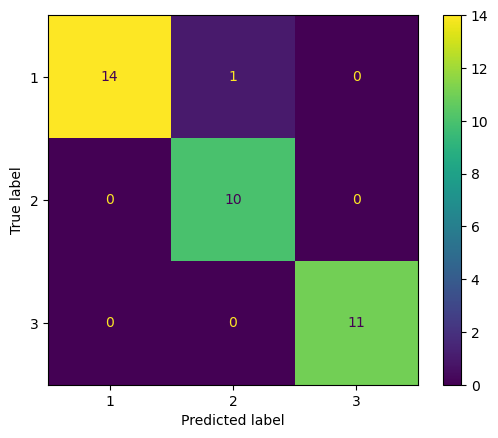

In [23]:
rf = RandomForestClassifier(random_state=0, 
                            max_depth=gs.best_params_['max_depth'], 
                            max_features=rs.best_params_['max_features'],
                            n_estimators=rs.best_params_['n_estimators'])
rf.fit(X_train, y_train)

my.plot_confusion_matrix_with_accuracy(rf, X_test, y_test)

Let's also calculate the model's micro and macro f1 scores.

In [24]:
print('Testing micro f1 score: ', f1_score(y_test, rf.predict(X_test), average="micro"))
print('Testing macro f1 score: ', f1_score(y_test, rf.predict(X_test), average="macro"))

Testing micro f1 score:  0.9722222222222222
Testing macro f1 score:  0.9726327312534209


### Feature importance

One great feature of Scikit-learn's implementation of random forests is the ability to calculate how important a feature is. According to Scikit-learn documentation, "Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it  Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. Let's see which feature(s) of the above random forest is more important".

Here is how to print and plot these importance values.

0.09 Alcohol
0.03 Malic acid
0.01 Ash
0.05 Alcalinity of ash
0.02 Magnesium
0.08 Total phenols
0.2 Flavanoids
0.01 Nonflavanoid phenols
0.01 Proanthocyanins
0.2 Color intensity
0.07 Hue
0.06 OD280/OD315 of diluted wines
0.17 Proline


Text(0.5, 1.0, 'Feature importance')

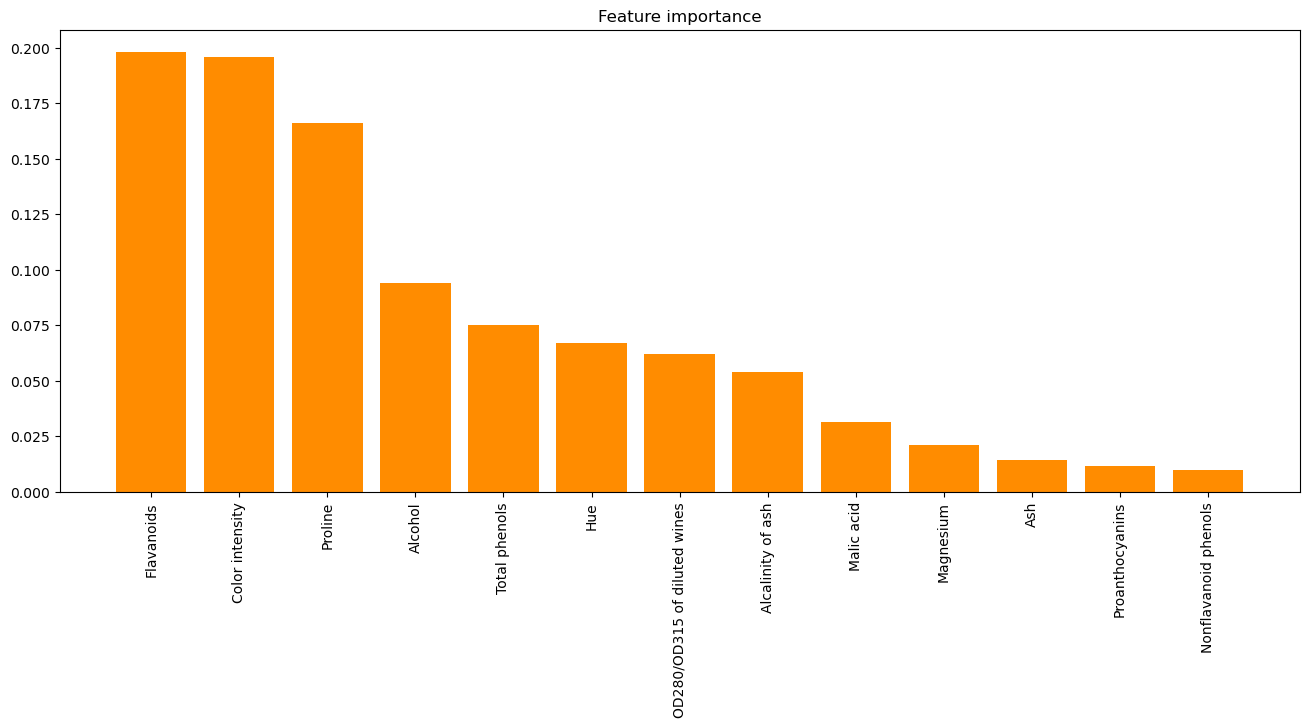

In [25]:
importances = rf.feature_importances_
for score, name in zip(importances, df.columns[:-1]):
    print(round(score, 2), name)
    
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.bar(range(X_train.shape[1]), importances[indices], align='center', color="darkorange")
plt.xticks(range(X_train.shape[1]), df.columns[:-1][indices], rotation=90)
plt.title('Feature importance')

## Boosting: AdaBoost
Boosting is another ensemble method technique that has resulted in some of the most popular machine learning models out there. It can reduce bais and variance and lead to models that are resilient to overfitting. Boosting is based on the question posed by Kearns and Valiant (1988, 1989): "Can a set of weak learners create a single strong learner?" In boosting, a weak learner is defined to be a classifier that is only slightly better than random guessing.

In this section, we'll see simple from scratch implementations of both AdaBoost and Gradient Boosting. We will be using SciKit Learn's decision trees as week learners.


Here is a simple implementation of the original AdaBoost algorithm discussed in class. This implementation:
* is for binary classification only.
* requires classes to be in the form of -1 and 1
* uses SciKit Learn's decision trees with a `max_depth` of 1 as week learners (stumps)

In [26]:
from sklearn.tree import DecisionTreeClassifier

class AdaBoostClassifier:
    def __init__(self, nTrees=20):
        self.nTrees = nTrees
        self.stumps = []

    def misclassification_error(self, actual, predicted, w):
        error = w[(actual != predicted)].sum()
        return error if error != 0.0 else 0.000001

    def fit(self, X, y):
        """ Create weights """
        N = len(y)
        W = np.zeros((self.nTrees+1) * N).reshape(N, self.nTrees+1)
        
        """ Initially, weights are the same and they sum up to 1 """
        W[:, 0] = np.full(N, 1 / N)

        self.alpha_ = []
        for i in range(self.nTrees):
            """ Create stump and train it using weights """
            stump = DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=W[:, i])

            
            """ Calculate error """
            h = stump.predict(X)
            err = self.misclassification_error(y, h, W[:, i])
            
            """ Update alpha """
            alpha = .5 * np.log((1 - err) / err)
            self.alpha_.append(alpha)

            """ Update weights """
            W[:, i + 1] = W[:, i] * np.exp(-alpha * y * h)
            W[:, i + 1] = W[:, i + 1]/W[:, i + 1].sum()
            
            """ Save stump """
            self.stumps.append(stump)
        
        return self
    
    def predict(self, X_unseen):
        labels = np.zeros(len(X_unseen))
        for i in range(self.nTrees):
            labels += self.alpha_[i] * self.stumps[i].predict(X_unseen)
            
        return np.where(labels <= 0, -1, 1)

Notice here that sampling based on the weight matrix is achieved by calling the fit function of the stumps in a special way:

``` python
    stump.fit(X, y, sample_weight=W[:, i])

```

To test, let's have SciKit Learn generate some data from us that is not leaner.

In [27]:
from sklearn.datasets import make_classification, make_gaussian_quantiles
X1, y1 = make_gaussian_quantiles(
    cov=3.0, n_samples=200, n_features=2, n_classes=2, random_state=11
)
X2, y2 = make_gaussian_quantiles(
    mean=(4, 3), cov=2.5, n_samples=300, n_features=2, n_classes=2, random_state=11
)
X = np.concatenate((X1, X2))
y = np.where(np.concatenate((y1, -y2 + 1)) == 0, -1, 1)

X.shape, y.shape

((500, 2), (500,))

Let's see how this data look:

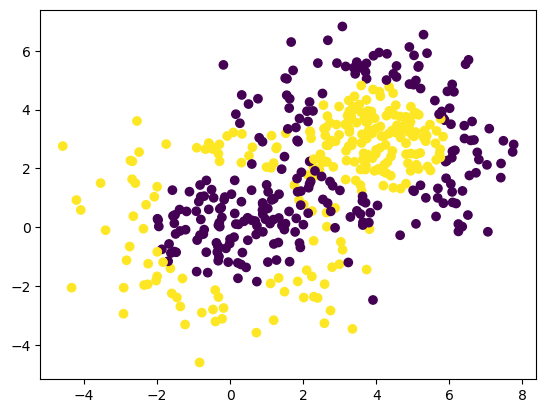

In [28]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

We now check how our implementation of AdaBoost fair on this data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

ada = AdaBoostClassifier(nTrees=20).fit(X_train, y_train)

In [30]:
cm = my.confusion_matrix(y_train, ada.predict(X_train))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

cm = my.confusion_matrix(y_test, ada.predict(X_test))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

[[168  23]
 [ 17 167]]
Training accuracy:  0.8933333333333333
[[52  7]
 [ 8 58]]
Testing accuracy:  0.88


And we can even see how the individual stumps perform on this data. The following shows the decision regions of the first 9 stumps. Clearly the overall AdaBoost classifier is doing much better that these individual week learners.

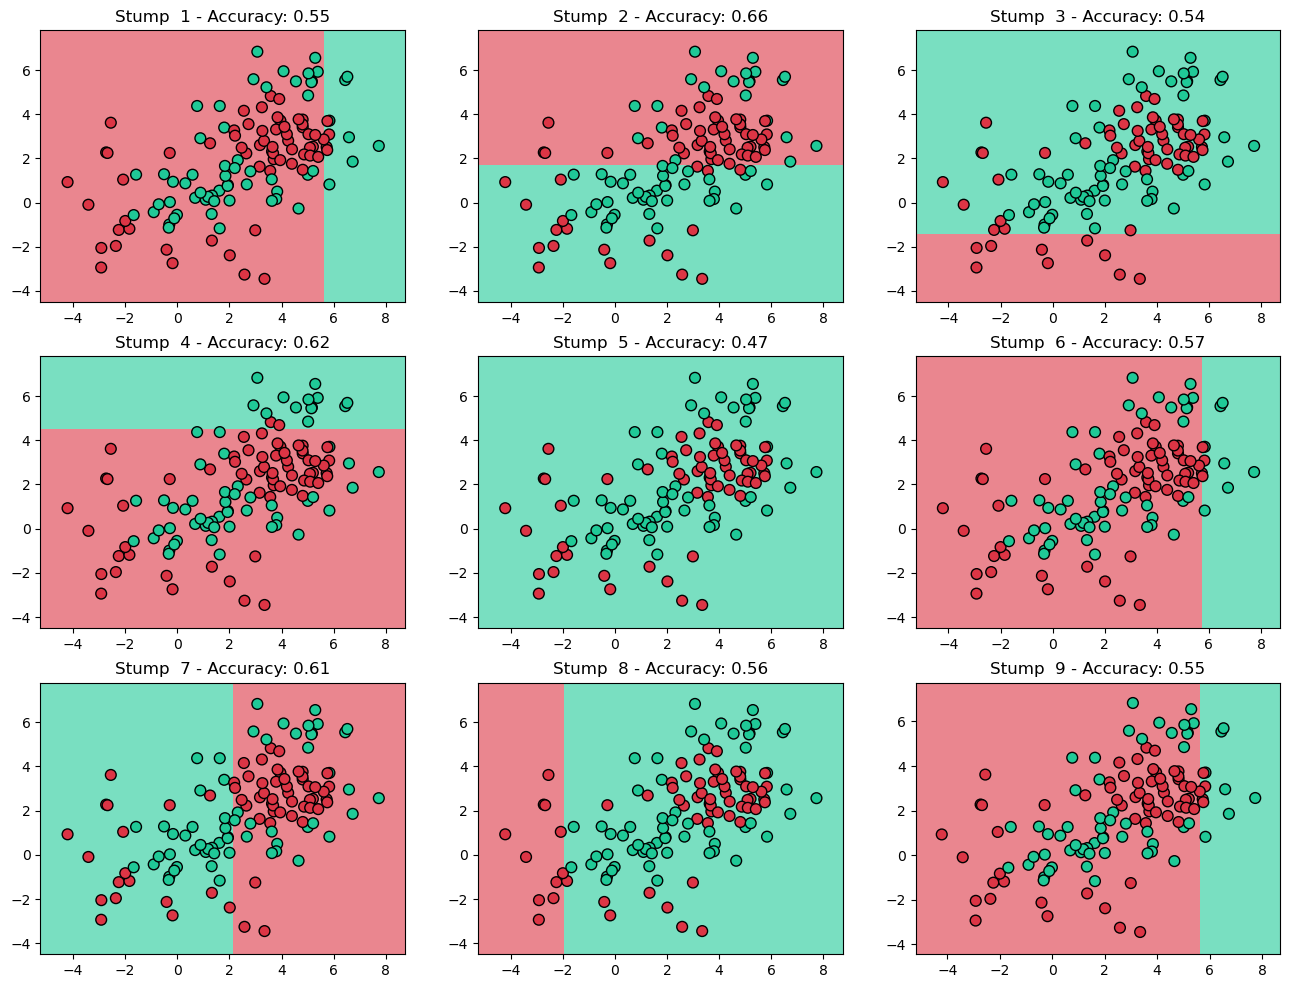

In [31]:
fig, axes = plt.subplots(3,3, figsize=(16,12))
for i in range(9):
    cm = my.confusion_matrix(y_test, ada.stumps[i].predict(X_test))
    accuracy = np.trace(cm) / np.sum(cm)
    my.plot_decision_regions(X_test, y_test, ada.stumps[i], 
                             title=f"Stump  {i + 1} - Accuracy: {accuracy:.2f}", ax=axes[i // 3, i % 3])

Do you think the last 9 stumps are better? I leave it as an exercise for you to find the answer.